## Reducing Dimensionality
**Please read the [Readme](https://github.com/ghanem-mhd/N-Balls-Visualization) for more information.**

In [19]:
import ipywidgets as widgets
import os, shutil
from ipywidgets import Layout

project_path        = os.path.dirname(os.getcwd())
data_path           = project_path + '/data'
output_path         = data_path + '/circles.txt'
children_file_path  = data_path + "/children.txt"
nballs_path         = data_path + "/nballs.txt"

balls_file_ready, children_file_ready = False, False

if not os.path.isdir(data_path):
    os.mkdir(data_path)

def reduce_and_fix(nball_file_path, children_file_path, output_path):
    reduce_and_fix_string_command = "../main.py --reduceAndFix --balls %s --children %s --output_path %s"
    command = reduce_and_fix_string_command%(nball_file_path, children_file_path, output_path)
    %run $command

balls_path_input    = widgets.FileUpload(accept='.txt', multiple=False, description="N-Balls")
children_path_input = widgets.FileUpload(accept='.txt', multiple=False, description="Children")
redcue_button       = widgets.Button(description='Reduce & Check', button_style='success')
files_upload_box    = widgets.Box([widgets.Label(value="Files:"), balls_path_input, children_path_input ])

def on_reduce_button_clicked(button):
    reduce_and_fix(nballs_path, children_file_path, output_path)
    redcue_button.disabled = True

def enable_reduce_button():
    global balls_file_ready, children_file_ready
    if balls_file_ready and children_file_ready:
        redcue_button.disabled = False
    else:
        redcue_button.disabled = True

def handle_upload_balls_file(change):
    global balls_file_ready, children_file_ready
    data = change['owner'].data[0].decode("utf-8")
    with open(nballs_path, 'w') as file:
        file.write(data)
    balls_path_input.disabled = True
    balls_file_ready = True
    enable_reduce_button()
    
def handle_upload_children_file(change):
    global balls_file_ready, children_file_ready
    data = change['owner'].data[0].decode("utf-8")
    with open(children_file_path, 'w') as file:
        file.write(data)
    children_path_input.disabled = True
    children_file_ready = True
    enable_reduce_button()

balls_path_input.observe(handle_upload_balls_file, names='data')
children_path_input.observe(handle_upload_children_file, names='data')
redcue_button.on_click(on_reduce_button_clicked)

# Start UI Interaction
def start():
    display(files_upload_box)
    redcue_button.disabled = True
    display(redcue_button)

start()

Box(children=(Label(value='Files:'), FileUpload(value={}, accept='.txt', description='N-Balls'), FileUpload(va…

Button(button_style='success', description='Reduce & Check', disabled=True, style=ButtonStyle())

## Visualization
**Please read the [Readme](https://github.com/ghanem-mhd/N-Balls-Visualization) for more information.**

Accordion(children=(VBox(children=(Box(children=(Label(value='Filter:'), ToggleButtons(options=('SubTree', 'In…

<IPython.core.display.Javascript object>


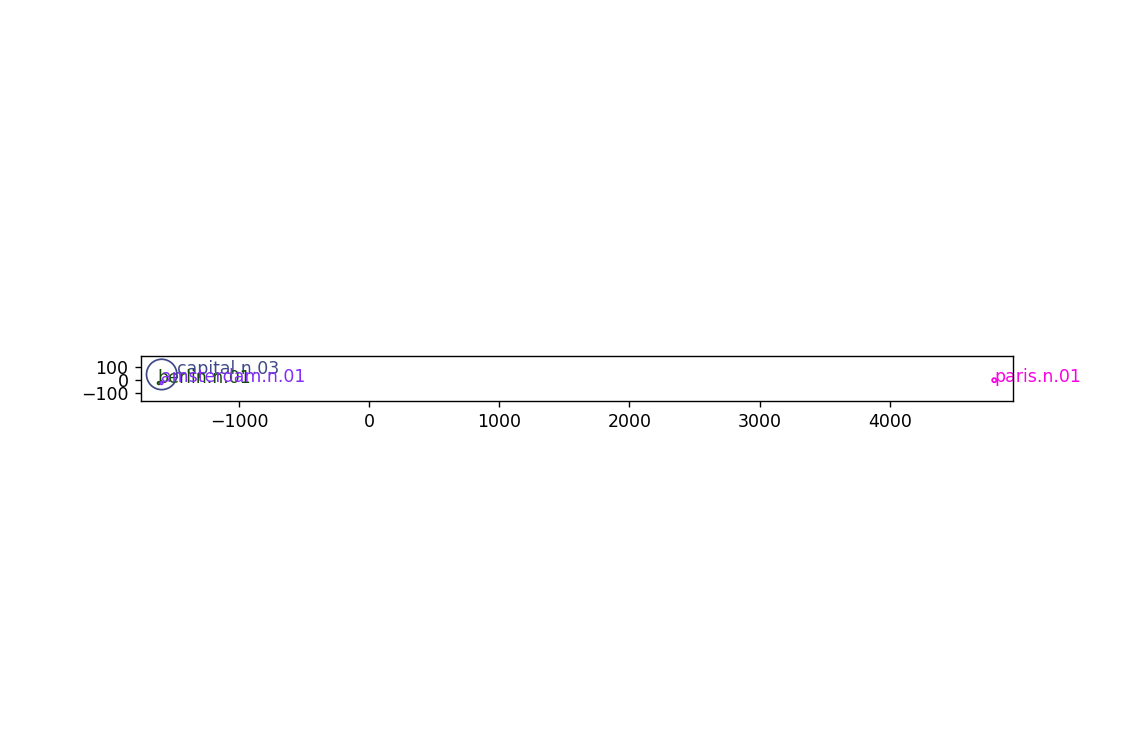

In [20]:
%matplotlib notebook
from matplotlib import pyplot
from matplotlib.patches import Circle
from math import pi, cos, sin
from ipywidgets import AppLayout, Layout, GridspecLayout,widgets
from IPython.display import clear_output
import numpy as np
import matplotlib.animation as animation
import random, os

project_path        = os.path.dirname(os.getcwd())
data_path           = project_path + '/data'
children_file_path  = data_path + "/children.txt"
before_fix_path     = data_path + "/circles_before.txt"
after_fix_path      = data_path + "/circles_after.txt"

ax,fig = None, None
circles_dic_before, circles_dic_after, children_dic, checkbox_dic, colors_dic, angles_dic = {}, {}, {}, {}, {}, {}
is_after, is_individual = True, False

# UI Widgets
select_all_button               = widgets.Button(description='Show All', button_style='success', layout=Layout(height='auto', width='auto'))
unselect_all_button             = widgets.Button(description='Hide All', button_style='danger', layout=Layout(height='auto', width='auto'))
select_unselect_all_box         = GridspecLayout(2, 1, height='auto')
filter_mode_toggle_button       = widgets.ToggleButtons(description='', options=['SubTree', 'Individual'], value='SubTree')
filter_mode_box                 = widgets.Box([widgets.Label(value="Filter:"), filter_mode_toggle_button])
vis_mode_toggle_button          = widgets.ToggleButtons(description='', options=['Before', 'After'], value='After')
mode_box                        = widgets.Box([widgets.Label(value="Circles:"),vis_mode_toggle_button])
margin                          = widgets.Label(value="")
select_unselect_all_box[0, 0]   = select_all_button
select_unselect_all_box[1, 0]   = unselect_all_button


def show_options(grid):
    global select_unselect_all_buttons_box, vis_mode_toggle_button, select_unselect_all_box
    extendted_grid = AppLayout(center=grid, right_sidebar=select_unselect_all_box, justify_items='center', align_items='center', pane_widths=[0,8, 1])
    options_list = widgets.VBox([filter_mode_box ,extendted_grid, margin, mode_box])
    accordion = widgets.Accordion(children=[options_list])
    accordion.set_title(0, 'Visulization Options')
    display(accordion)

def generate_colors(words):
    global colors_dic, angles_dic
    angles = random.sample(list(np.arange(0, 2 * pi, 2*pi/ len(words))), len(words))
    colors = ["#" + ''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(len(words))]
    for i, word  in enumerate(words):
        colors_dic[word] = colors[i]
        angles_dic[word] = angles[i]
    
def read_files():
    global circles_dic_before, circles_dic_after
    read_balls_file(before_fix_path, circles_dic_before)
    read_balls_file(after_fix_path, circles_dic_after)
    read_children_file(children_file_path, children_dic)
    words = list(circles_dic_after.keys())
    create_checkbox_grid(words)
    generate_colors(words)
    plot_dic("", [])
    
def read_balls_file(file_path, circles_dic=None):
    if circles_dic is None:
        circles_dic = dict()
    with open(file_path, mode="r", encoding="utf-8") as balls_file:
        for line in balls_file.readlines():
            tokens = line.strip().split()
            circles_dic[tokens[0]] = [float(ele) for ele in tokens[1:]]
        return circles_dic
    
def read_children_file(ws_children_file, children_dic=None):
    if children_dic is None:
        children_dic = dict()
    with open(ws_children_file, 'r') as children_file:
        for ln in children_file:
            tokens = ln[:-1].split()
            children_dic[tokens[0]] = tokens[1:]
        return children_dic

def create_checkbox_grid(words):
    words.sort()
    global ax, fig, checkbox_dic, gride
    for word in words:
        checkbox_changed = widgets.Checkbox(value=True, description=word)
        checkbox_changed.observe(checkbox_changed_callback)
        checkbox_dic[word] = checkbox_changed
    grid = widgets.GridBox(list(checkbox_dic.values()), layout=widgets.Layout(grid_template_columns="repeat(5, 150px)"))
    show_options(grid)
    fig, ax = pyplot.subplots()
    ax.set_aspect(1)
    fig.set_figheight(6)
    fig.set_figwidth(9)
    
def random_point(xy, r, theta):
    return xy[0] + cos(theta) * float(r), xy[1] + sin(theta) * float(r)
    
def plot(vectors, radius, words, fig, ax):
    global checkbox_dic, colors_dic, angles_dic
    for i, vector in enumerate(np.array(vectors)):
        e = Circle(xy=vector, radius=float(radius[i]))
        ax.add_artist(e)
        e.set_edgecolor(colors_dic[words[i]])
        e.set_facecolor('none')

    x = [i[0] for i in vectors]
    y = [i[1] for i in vectors]
    max_radius = max(radius)
    if max_radius < 1:
        max_radius = 1
    margin = 1.2 * max_radius
    ax.set_xlim([min(x) - margin, max(x) + margin])
    ax.set_ylim([min(y) - margin, max(y) + margin])
    ax.set_aspect(1)

    for i, word in enumerate(words):
        text_location = random_point(vectors[i], radius[i], angles_dic[word])
        ax.text(text_location[0], text_location[1], '%s' % (str(word)), size=10, zorder=1, color=colors_dic[words[i]])
    fig.show()

def plot_dic(figure_title, filtered_words=[]):
    global is_after
    if is_after:
        circles_dic = circles_dic_after
    else:
        circles_dic = circles_dic_before
    if len(filtered_words) > 0:
        circles_dic = {k: circles_dic[k] for k in filtered_words if k in circles_dic}
    words = list(circles_dic.keys())
    radius = [values[-1] for values in circles_dic.values()]
    vectors = [np.multiply(np.array(values[:2]), values[-2]) for values in circles_dic.values()]
    plot(vectors, radius, words, fig, ax)

def update_plot():
    pyplot.cla()
    showen_words = set()
    for word,checkbox in checkbox_dic.items():
        if checkbox.value:
            showen_words.add(word)
    if len(showen_words) == 0:
        pyplot.cla()
    else:
        plot_dic("", showen_words)
        
def disable_sub_tree(word):
    checkbox_dic[word].unobserve_all()
    checkbox_dic[word].value = False
    checkbox_dic[word].observe(checkbox_changed_callback)
    children = children_dic[word]
    if len(children) > 0:
        for child in children:
            disable_sub_tree(child)
            
def enable_parents(word):
    parent = None
    for key, chilren in children_dic.items():
        if word in set(chilren):
            parent = key
            break
    if parent and parent != '*root*':
        checkbox_dic[parent].unobserve_all()
        checkbox_dic[parent].value = True
        checkbox_dic[parent].observe(checkbox_changed_callback)
        enable_parents(parent)
    
def checkbox_changed_callback(b):
    global is_individual
    if b['type'] == 'change' and b['name'] == 'value':
        check_word = b['owner'].description
        check_status = b['owner'].value
        if is_individual:
            set_state_to_check_box(checkbox_dic[check_word], check_status)
        else:
            if not check_status: # uncheck case    
                disable_sub_tree(check_word)
            else: # check case   
                enable_parents(check_word)
        update_plot()


# UI Widget functions
def on_visualize_balls_button_clicked(button):
    nball_file_path = nball_path_input.value
    reduce_and_plot(nball_file_path)
    nball_input_buttons_box.layout.visibility = 'hidden'
    
def set_state_to_check_box(checkbox, state):
    checkbox.unobserve_all()
    checkbox.value = state
    checkbox.observe(checkbox_changed_callback)
        
def set_state_to_all_checkboxs(state):
    for word,checkbox in checkbox_dic.items():
        set_state_to_check_box(checkbox, state)
    
def on_select_all_button_clicked(button):
    set_state_to_all_checkboxs(True)
    update_plot()
    
def on_unselect_all_button_clicked(button):
    set_state_to_all_checkboxs(False)
    update_plot()
    
def filter_mode_changed_callback(b):
    global is_individual
    if b['type'] == 'change' and b['name'] == 'value':
        if b['new'] == 'Individual':
            is_individual = True
        else:
            is_individual = False

def vis_mode_changed_callback(b):
    global is_after
    if b['type'] == 'change' and b['name'] == 'value':
        if b['new'] == 'After':
            is_after = True
        else:
            is_after = False
        update_plot()
    
# Set Widget listeners
select_all_button.on_click(on_select_all_button_clicked)
unselect_all_button.on_click(on_unselect_all_button_clicked)
filter_mode_toggle_button.observe(filter_mode_changed_callback)
vis_mode_toggle_button.observe(vis_mode_changed_callback)

# Start UI Interaction
def start():
    if os.path.exists(children_file_path) and os.path.exists(before_fix_path) and os.path.exists(after_fix_path):
        read_files()
    else:
        print("Please run the second cell first to generate circles files.")
start()